### Rapidly-exploring Random Tree Star (`RRT*`) in 2D

In [1]:
import cv2,sys,glob
import numpy as np
import mediapy as media
from shapely import Polygon
sys.path.append('../package/helper/')
sys.path.append('../package/planning/')
from utility import *
from transformation import *
from rrt import RapidlyExploringRandomTreesStarClass
print ("Ready.")

Ready.


In [2]:
RRT = RapidlyExploringRandomTreesStarClass(
    name='RRT-Star-2D',point_min=np.array([-1,-1]),point_max=np.array([+1,+1]),
    goal_select_rate=0.05,steer_len_max=0.1,search_radius=0.2,norm_ord=2,
    n_node_max=2000,TERMINATE_WHEN_GOAL_REACHED=False,SPEED_UP=True)
print ("[%s] instantiated."%(RRT.name))

[RRT-Star-2D] instantiated.


In [3]:
np.random.seed(seed=0)
width,height,n_obs = 0.1,1.0,8
box = np.array([[-width/2,-height/2],[width/2,-height/2],
                [width/2,height/2],[-width/2,height/2]])
obs_list = []
for _ in range(n_obs):
    box_translate = box@rot_mtx(360*np.random.rand()) + (-1+2*np.random.rand(1,2))
    obs_list.append(Polygon(box_translate))
print ("Ready.")

Ready.


In [4]:
# Remove images
png_paths = sorted(glob.glob('./.tmp/rrt_star_*.png'))
for png_path in png_paths:
    # print ("[%s] removed."%(png_path))
    os.remove(png_path)
print ("[%d] images removed."%(len(png_paths)))

[0] images removed.


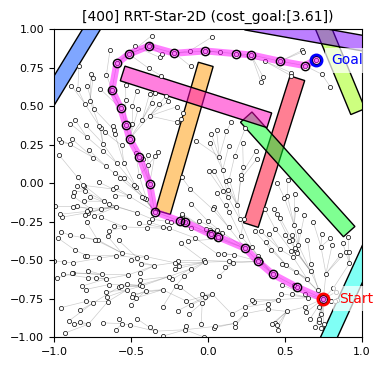

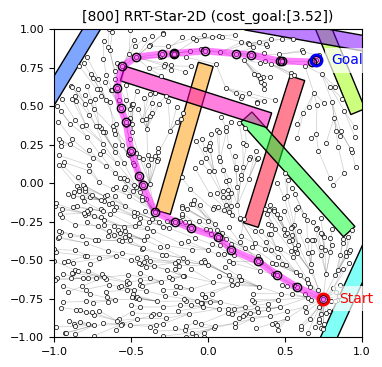

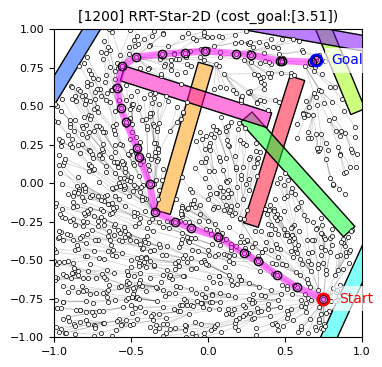

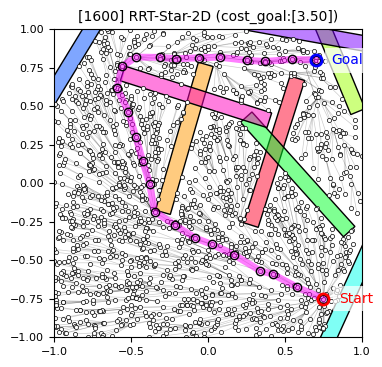

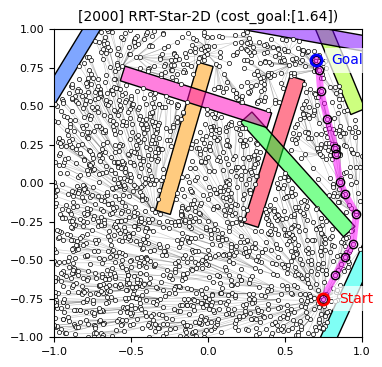

Done.


In [5]:
point_root,point_goal=np.array([0.75,-0.75]),np.array([0.7,0.8])
RRT.init_rrt_star(point_root=point_root,point_goal=point_goal)
while True:
    # Number of nodes
    n_node = RRT.get_n_node()
    if n_node > RRT.n_node_max: break
    
    # Randomly sample a point
    while True:
        if np.random.rand() <= RRT.goal_select_rate: point_sample = RRT.point_goal 
        else: point_sample = RRT.sample_point() # random sampling
        if is_point_feasible(point_sample,obs_list): break
    
    # Get the nearest node ('node_nearest') to 'point_sample' from the tree
    node_nearest = RRT.get_node_nearest(point_sample)
    point_nearest = RRT.get_node_point(node_nearest)
    
    # Steering towards 'point_sample' to get 'point_new'
    point_new,cost_new = RRT.steer(node_nearest,point_sample)
    if point_new is None: continue # if the steering point is feasible

    # Rewiring
    if is_point_feasible(point_new,obs_list) \
        and is_point_to_point_connectable(point_nearest,point_new,obs_list):
        
        # Assign 'node_min' and initialize 'cost_min' with 'cost_new'
        node_min = node_nearest.copy()
        cost_min = cost_new
        
        # Select a set of nodes near 'point_new' => 'nodes_near'
        nodes_near = RRT.get_nodes_near(point_new)
        
        # For all 'node_near' find 'node_min'
        for node_near in nodes_near:
            point_near,cost_near = RRT.get_node_point_and_cost(node_near)
            if is_point_to_point_connectable(point_near,point_new,obs_list):
                cost_prime = cost_near + RRT.get_dist(point_near,point_new)
                if cost_prime < cost_min:
                    cost_min = cost_near + RRT.get_dist(point_near,point_new)
                    node_min = node_near
                    
        # Add 'node_new' and connect it with 'node_min'
        node_new = RRT.add_node(point=point_new,cost=cost_min,node_parent=node_min)
        
        # New node information for rewiring
        point_new,cost_new = RRT.get_node_point_and_cost(node_new)
        
        # Rewire
        for node_near in nodes_near:
            if node_near == 0: continue
            if RRT.get_node_parent(node_near) == node_new: continue
            point_near,cost_near = RRT.get_node_point_and_cost(node_near)
            cost_check = cost_new+RRT.get_dist(point_near,point_new)
            if (cost_check < cost_near) and \
                is_point_to_point_connectable(point_near,point_new,obs_list):
                RRT.replace_node_parent(node=node_near,node_parent_new=node_new)
        
        # Re-update cost of all nodes
        if RRT.SPEED_UP: node_source = node_min
        else: node_source = 0
        RRT.update_nodes_cost(node_source=node_source,VERBOSE=False)
        
    # Save images
    SAVE_PNG = True
    if ((RRT.get_n_node() % (RRT.n_node_max//200)) == 0) and SAVE_PNG:
        cost_goal = RRT.get_cost_goal()
        titlestr = '[%d] %s (cost_goal:[%.2f])'%(RRT.get_n_node(),RRT.name,cost_goal)
        if not os.path.exists('./.tmp'): os.makedirs('./.tmp')
        png_path = './.tmp/rrt_star_%05d.png'%(RRT.get_n_node())
        RRT.plot_tree_custom(
            figsize=(5,4),
            xlim=(RRT.point_min[0],RRT.point_max[0]),
            ylim=(RRT.point_min[1],RRT.point_max[1]),
            nodems=3,nodemec='k',nodemfc='w',nodemew=1/2,
            edgergba=[0,0,0,0.2],edgelw=1/2,
            startrgb=[1,0,0],startms=8,startmew=2,startfs=10,
            startbbalpha=0.7,start_xoffset=0.1,
            goalrgb=[0,0,1],goalms=8,goalmew=2,goalfs=10,
            goalbbalpha=0.7,goal_xoffset=0.1,
            pathrgba=[1,0,1,0.5],pathlw=5,pathtextfs=8,
            obs_list=obs_list,obsrgba=None,obsec='k',
            textfs=8,titlestr=titlestr,titlefs=10,
            PLOT_PATH_TEXT=False,PLOT_FULL_TEXT=False,
            SAVE_PNG=True,png_path=png_path,VERBOSE=False)
        
    # Plot image
    DEBUG_PLOT = True
    if ((RRT.get_n_node() % (RRT.n_node_max//5)) == 0) and DEBUG_PLOT:
        cost_goal = RRT.get_cost_goal()
        titlestr = '[%d] %s (cost_goal:[%.2f])'%(RRT.get_n_node(),RRT.name,cost_goal)
        RRT.plot_tree_custom(
            figsize=(5,4),
            xlim=(RRT.point_min[0],RRT.point_max[0]),
            ylim=(RRT.point_min[1],RRT.point_max[1]),
            nodems=3,nodemec='k',nodemfc='w',nodemew=1/2,
            edgergba=[0,0,0,0.2],edgelw=1/2,
            startrgb=[1,0,0],startms=8,startmew=2,startfs=10,
            startbbalpha=0.7,start_xoffset=0.1,
            goalrgb=[0,0,1],goalms=8,goalmew=2,goalfs=10,
            goalbbalpha=0.7,goal_xoffset=0.1,
            pathrgba=[1,0,1,0.5],pathlw=5,pathtextfs=8,
            obs_list=obs_list,obsrgba=None,obsec='k',
            textfs=8,titlestr=titlestr,titlefs=10,
            PLOT_PATH_TEXT=False,PLOT_FULL_TEXT=False,
            SAVE_PNG=False,VERBOSE=False)

    # Terminate condition
    dist_to_goal = RRT.get_dist_to_goal()
    if (dist_to_goal < 1e-6) and RRT.TERMINATE_WHEN_GOAL_REACHED:
        print ("Goad reached. n_node:[%d] dist_to_goal:[%.4f]"%
               (RRT.get_n_node(),dist_to_goal))
        break
print ("Done.")

#### Make a video

In [6]:
png_paths = sorted(glob.glob('./.tmp/rrt_star_*.png'))
frames = []
for png_path in png_paths:
    img_bgr = cv2.imread(png_path)
    img_rgb = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)
    frames.append(img_rgb)
media.show_video(frames, fps=30)

#### Get path to goal

In [7]:
path_to_goal,path_node_list = RRT.get_path_to_goal()
for node_idx,node in enumerate(path_node_list):
    print ("[%d/%d] node:[%d] point:%s cost:[%.2f]"%
           (node_idx,len(path_node_list),node,RRT.get_node_point(node),
            RRT.get_node_cost(node)))
print ("Done.")

[0/13] node:[0] point:[ 0.75 -0.75] cost:[0.00]
[1/13] node:[522] point:[ 0.82678432 -0.59798904] cost:[0.17]
[2/13] node:[1415] point:[ 0.89241292 -0.48164022] cost:[0.30]
[3/13] node:[1449] point:[ 0.94185352 -0.39517383] cost:[0.40]
[4/13] node:[1640] point:[ 0.96462842 -0.20128123] cost:[0.60]
[5/13] node:[800] point:[ 0.89160713 -0.07168722] cost:[0.75]
[6/13] node:[1929] point:[0.8563084  0.01003388] cost:[0.84]
[7/13] node:[1659] point:[0.8301227  0.18968947] cost:[1.02]
[8/13] node:[1960] point:[0.82739995 0.22688547] cost:[1.06]
[9/13] node:[1741] point:[0.77530102 0.41984368] cost:[1.26]
[10/13] node:[1147] point:[0.73215514 0.59971435] cost:[1.44]
[11/13] node:[1810] point:[0.72084167 0.73873785] cost:[1.58]
[12/13] node:[376] point:[0.7 0.8] cost:[1.64]
Done.


#### Plot final path

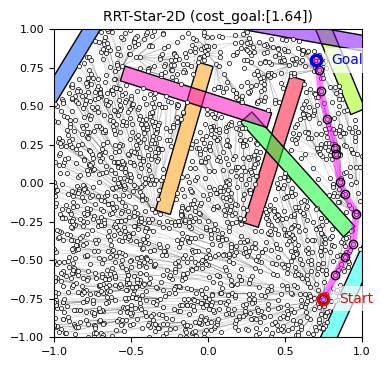

In [8]:
titlestr = '%s (cost_goal:[%.2f])'%(RRT.name,cost_goal)
RRT.plot_tree_custom(
    figsize=(4,4),
    xlim=(RRT.point_min[0],RRT.point_max[0]),
    ylim=(RRT.point_min[1],RRT.point_max[1]),
    nodems=3,nodemec='k',nodemfc='w',nodemew=1/2,
    edgergba=[0,0,0,0.2],edgelw=1/2,
    startrgb=[1,0,0],startms=8,startmew=2,startfs=10,startbbalpha=0.7,start_xoffset=0.1,
    goalrgb=[0,0,1],goalms=8,goalmew=2,goalfs=10,goalbbalpha=0.7,goal_xoffset=0.1,
    pathrgba=[1,0,1,0.5],pathlw=5,pathtextfs=10,
    obs_list=obs_list,obsrgba=None,obsec='k',
    textfs=8,titlestr=titlestr,titlefs=10,
    PLOT_PATH_TEXT=False,PLOT_FULL_TEXT=False)

In [9]:
# Remove images
png_paths = sorted(glob.glob('./.tmp/rrt_star_*.png'))
for png_path in png_paths:
    # print ("[%s] removed."%(png_path))
    os.remove(png_path)
print ("[%d] images removed."%(len(png_paths)))

[200] images removed.
